### 1. Import libraries

In [1]:
from ezyrb import POD, AE, GPR, ANN, RBF, Database
from ezyrb import ReducedOrderModel as ROM
import torch
import torch.nn as nn

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
np.bool = np.bool_ # to avoid error in pyvista

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [2]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [3]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [4]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. AE evaluation

In [5]:
def PODI_rom(ae, model, train_design_parameters, train_data):
    # Define the database
    db = Database(train_design_parameters, train_data)
    # Define the ROM
    rom = ROM(db, ae, model)
    rom.fit()

    return rom

### 4. ANN prediction

In [19]:
# Normalize the training data
p_scaler = StandardScaler()
train_pressure_scaled = p_scaler.fit_transform(train_pressure)

# Evaluate AE on the pressure data
low_dim = 20
optim = torch.optim.Adam
encoder_list = [3000, 500, 100, low_dim]
decoder_list = [low_dim, 1000]
encoder_activation = torch.nn.Tanh
decoder_activation = torch.nn.Tanh

p_ae = AE(encoder_list, decoder_list, encoder_activation(), decoder_activation(), 
          [500, 1e-5], optimizer=optim, frequency_print=50, loss=torch.nn.MSELoss())

# Define the ANN model
p_ann = ANN([5, 10], nn.Tanh(), [2000,1e-5])

# Perform PODI on the pressure data
p_rom = PODI_rom(p_ae, p_ann, train_design_parameters, train_pressure)

# Predict the pressure data
p_predict = p_rom.predict(test_design_parameters)

# calculate the reconstrcuted error for each test data using mean squared error
p_reconstructed_error = np.linalg.norm(test_pressure - p_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_pressure, axis=1)

# plot the error
plt.bar([i for i in range(len(p_reconstructed_error))], p_reconstructed_error)
plt.title('Pressure reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

[epoch      1]	2.094606e-01
[epoch     50]	5.244066e-04
[epoch    100]	4.478070e-04
[epoch    150]	4.474987e-04
[epoch    200]	4.474953e-04
[epoch    250]	5.717637e-04
[epoch    300]	4.478617e-04


KeyboardInterrupt: 

In [9]:
u_error_list = []
rank_range = [i for i in range(2, 10, 2)] + [i for i in range(10, 41, 5)]

# Normalize the training data
u_scaler = StandardScaler()
train_velocity_scaled = u_scaler.fit_transform(train_velocity)

for i in rank_range:   

    # Evaluate AE on the pressure data
    low_dim = i
    print(f'The latent coordinate: {i}')
    optim = torch.optim.Adam
    encoder_list = [2000, low_dim]
    decoder_list = [low_dim, 2000]
    encoder_activation = torch.nn.Tanh
    decoder_activation = torch.nn.Tanh

    u_ae = AE(encoder_list, decoder_list, encoder_activation(), decoder_activation(), 
            [1000, 1e-3], optimizer=optim, frequency_print=100)

    # Define the ANN model
    u_ann = ANN([5, 20], nn.Tanh(), [5000,1e-4], frequency_print=500)

    # Perform PODI on the pressure data
    u_rom = PODI_rom(u_ae, u_ann, train_design_parameters, train_velocity_scaled)

    # Predict the pressure data
    u_predict_scaled = u_rom.predict(test_design_parameters)
    u_predict = u_scaler.inverse_transform(u_predict_scaled.snapshots_matrix)

    # calculate the reconstrcuted error for each test data using mean squared error
    u_error_list.append(np.linalg.norm(test_velocity - u_predict, axis=1) / np.linalg.norm(test_velocity, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(u_reconstructed_error))], u_reconstructed_error)
    # plt.title('Velocity reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

The latent coordinate: 2
[epoch      1]	1.049749e+00
[epoch     20]	6.368380e-01
[epoch     40]	4.739517e-01
[epoch     60]	4.044950e-01
[epoch     80]	3.698412e-01
[epoch    100]	3.455020e-01
[epoch    120]	3.227957e-01
[epoch    140]	3.005519e-01
[epoch    160]	2.803793e-01
[epoch    180]	2.628218e-01
[epoch    200]	2.469911e-01
[epoch    220]	2.340215e-01
[epoch    240]	2.281634e-01
[epoch    260]	2.167013e-01
[epoch    280]	2.044551e-01
[epoch    300]	1.944693e-01
[epoch    320]	1.866947e-01
[epoch    340]	1.800738e-01
[epoch    360]	1.741403e-01
[epoch    380]	1.684235e-01
[epoch    400]	1.631390e-01
[epoch    420]	1.582661e-01
[epoch    440]	1.539226e-01
[epoch    460]	1.508237e-01
[epoch    480]	1.493859e-01
[epoch    500]	1.466085e-01
[epoch    520]	1.515429e-01
[epoch    540]	1.464211e-01
[epoch    560]	1.437803e-01
[epoch    580]	1.383797e-01
[epoch    600]	1.314239e-01
[epoch    620]	1.272710e-01
[epoch    640]	1.235147e-01
[epoch    660]	1.200359e-01
[epoch    680]	1.166932

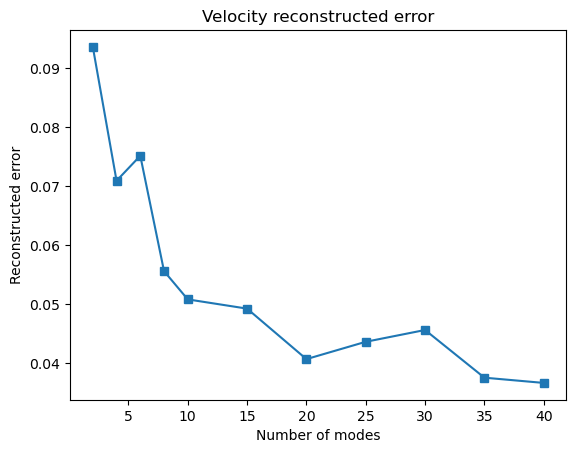

In [10]:
# print the error using different number of modes
u_error = np.array(u_error_list)
u_error_mean = np.mean(u_error, axis=1)

plt.plot(rank_range, u_error_mean, marker='s')
plt.title('Velocity reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

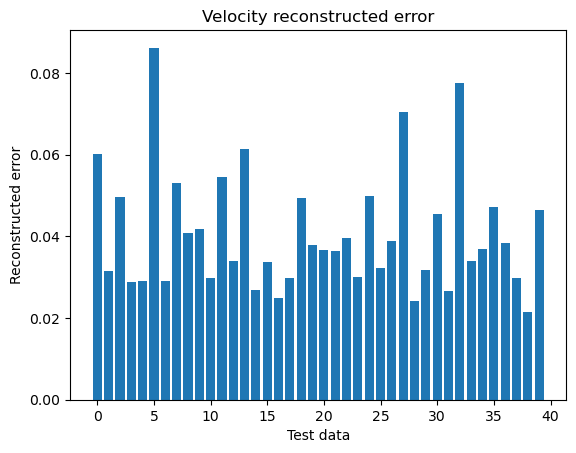

In [13]:
# plot the error of each case when using 22 modes
plt.bar([i for i in range(len(u_error_list[6]))], u_error_list[6])
plt.title('Velocity reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

### 5. VTK visualization

In [ ]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [18]:
# write the truth data, reconstructed data, and error into a VTK file
# Load the reference mesh VTM file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
p_error_field = test_pressure - p_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_pressure)):
    vtk_writer([test_pressure[i], p_predict.snapshots_matrix[i], p_error_field[i]], 
                field_name, 'scalar', refVTM, f'visualization_data/EZyRB_AE_ANN/test_case_{i}_pressure', test_points[i])

In [19]:
# Write the velocity data into VTK file
field_name = ['truth', 'reconstructed', 'error']
u_error_field = test_velocity - u_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_velocity)):
    vtk_writer([test_velocity[i], u_predict.snapshots_matrix[i], u_error_field[i]], 
                field_name, 'vector', refVTM, f'visualization_data/EZyRB_AE_ANN/test_case_{i}_velocity', test_points[i])